In [49]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
import pandas as pd
import sklearn.preprocessing
import sklearn.compose
import sklearn.impute
import seaborn as sns
import pyprojroot
import importlib
import janitor
import pyreadr
import missingno
sys.path.append(str(pyprojroot.here()))
import src.utils
import src.pandas_missing_extension
importlib.reload(src.pandas_missing_extension)
importlib.reload(src.utils)
from src.utils import load_and_clean_nhanes_data

In [36]:
nhanes_df = load_and_clean_nhanes_data()
nhanes_df.head()

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


# Mean, median, and mode imputation

Make imputation

In [3]:
(
    nhanes_df
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676386

Show results

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<AxesSubplot:xlabel='height', ylabel='weight'>

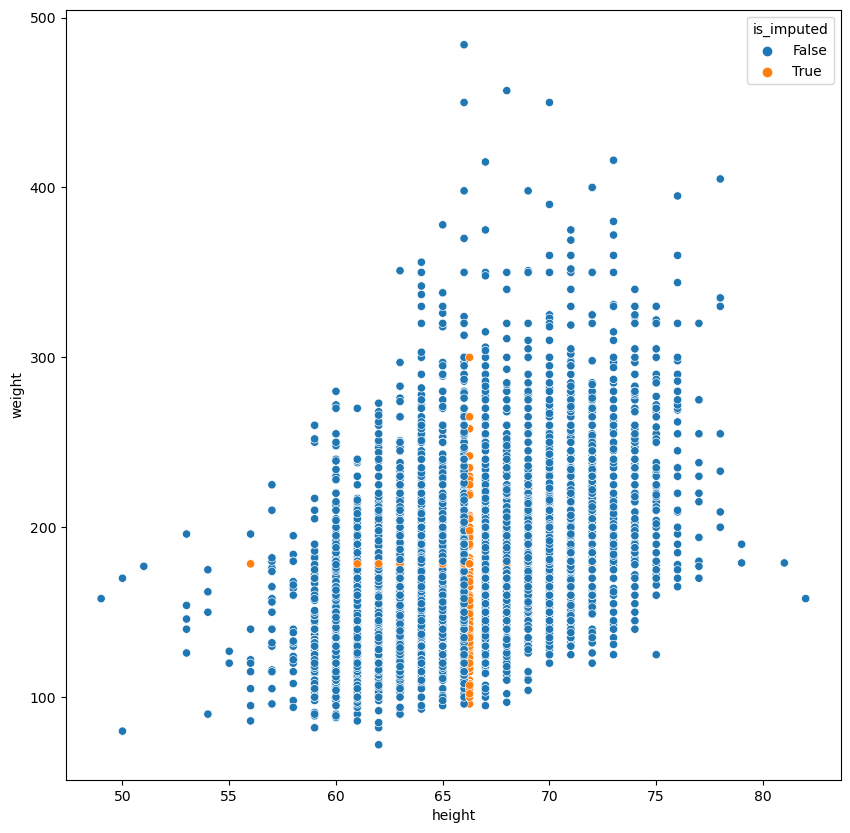

In [6]:
plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


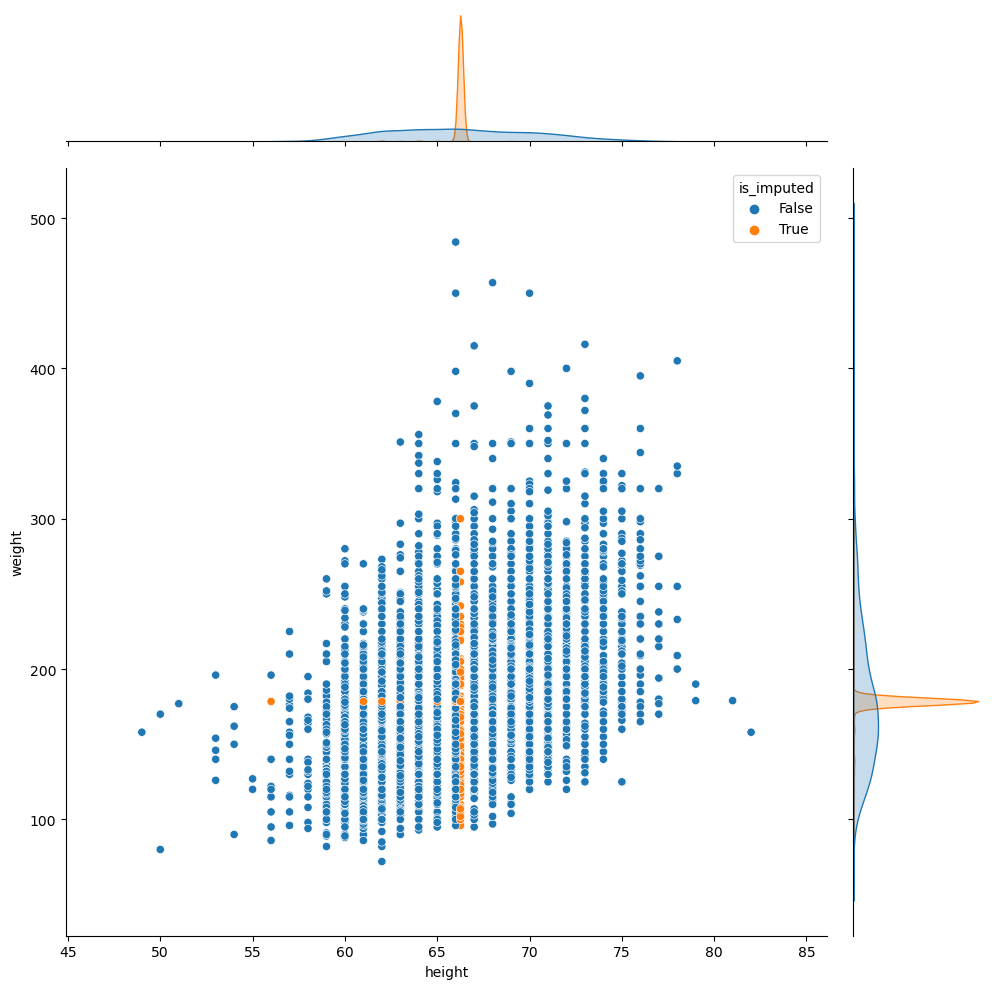

In [7]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

# Backward fill imputation and forward fill imputation

fillna() vs ffill() o bfill()

In [8]:
(
    nhanes_df
    .select_columns("height", "weight")
    # .fillna(method = "ffill")
    .ffill()    # fill row with previous row's value
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recommendations for Imputing Values Using ffill() or bfill()

Imputation within domains and imputation through correlated variables

In [ ]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")   # select releated columns
    .sort_values(   # sort values
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(  # impute missing values
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

### Challenge: Compare imputation results between sort_values and group_by

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


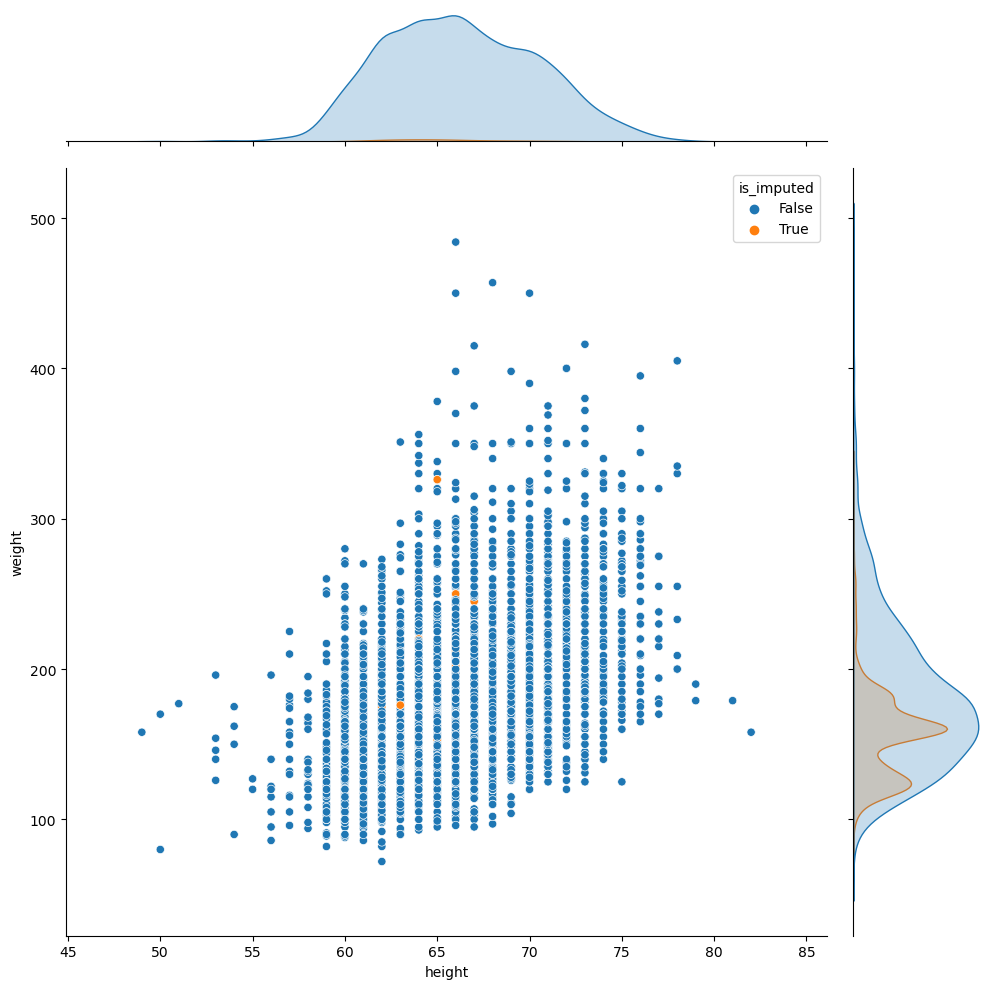

In [9]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")   # select releated columns
    .sort_values(   # sort values
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .transform_column(  # impute missing values
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

1669


/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_32564/3072238982.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda group: (


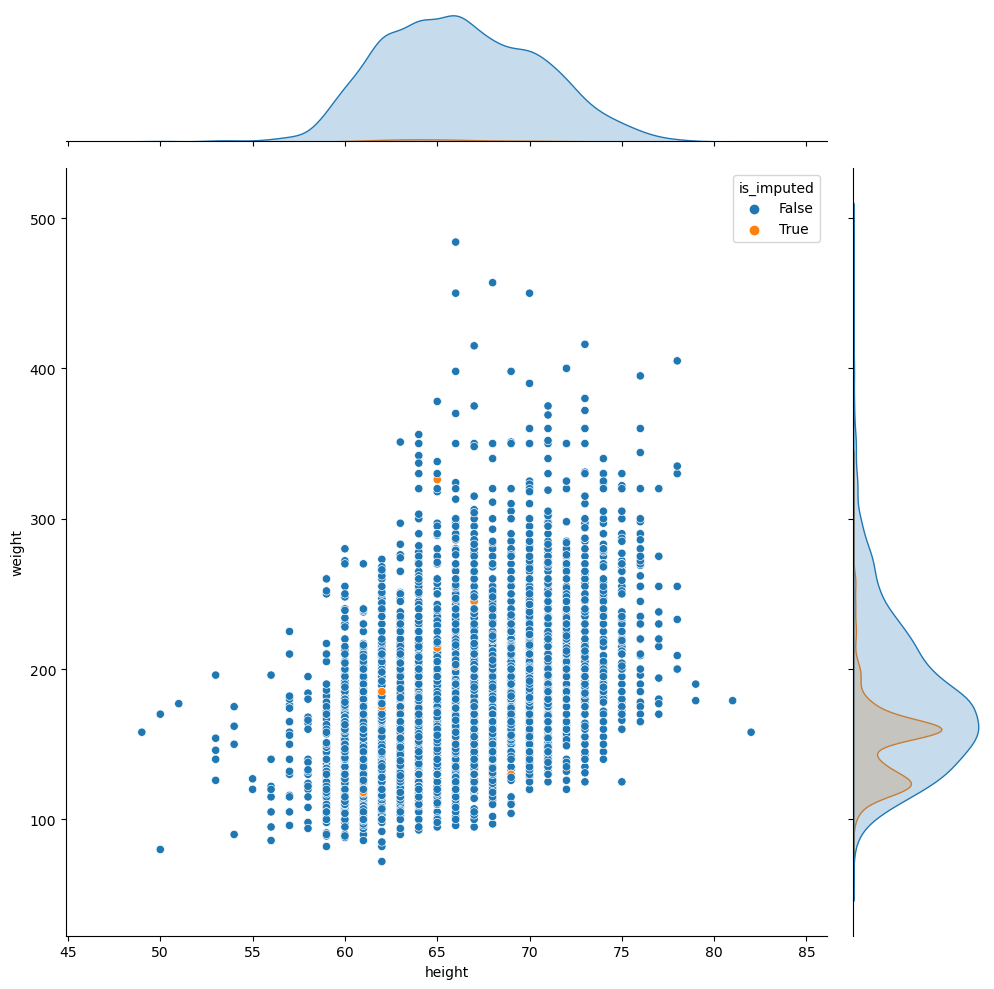

In [38]:
print(nhanes_df['height'].isna().sum())
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    # .sort_values(by=["gender", "diabetes", "general_health_condition", "height"], ascending=True)
    .groupby(["gender", "diabetes", "general_health_condition", "height"], dropna=False)
    .apply(lambda group: (
        group
        .missing.bind_shadow_matrix(True, False, suffix="_imp")
        .transform_column("weight", lambda x: x.ffill(), elementwise=False)
    ))
    .reset_index(drop=True)  # Reconstruir el índice para obtener un DataFrame limpio
    # .pipe(missingno.matrix)
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

# Interpolation imputation

#### What does it consist of?

This method estimates missing values using mathematical interpolation, which fits a function to known data points to predict the missing values.

#### When is it useful?

- When the data has a temporal or sequential relationship, such as time series.
- In numerical data with a clear trend or underlying pattern.
- When missing values are surrounded by known values (it does not work well for values at the beginning or end of the series).

In [ ]:
# The "airquality" dataset have temporal data
airquality_df = (
    sm.datasets.get_rdataset("airquality")  # Retrieves the 'airquality' dataset from the statsmodels library
    .data  # Accesses the dataset's data
    .clean_names(  # Cleans the column names to make them more readable
        case_type = "snake"  # Converts the column names to 'snake_case' (lowercase letters with underscores)
    )
    .add_column("year", 1973)  # Adds a new column called 'year' with the value 1973 for all rows
    .assign(  # Assigns a new calculated column
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])  # Creates a new 'date' column by combining 'year', 'month', and 'day' into a datetime object
    )
    .sort_values(by = "date")  # Sorts the data by the 'date' column in ascending order
    .set_index("date")  # Sets the 'date' column as the index of the DataFrame
)

airquality_df

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<AxesSubplot:xlabel='date'>

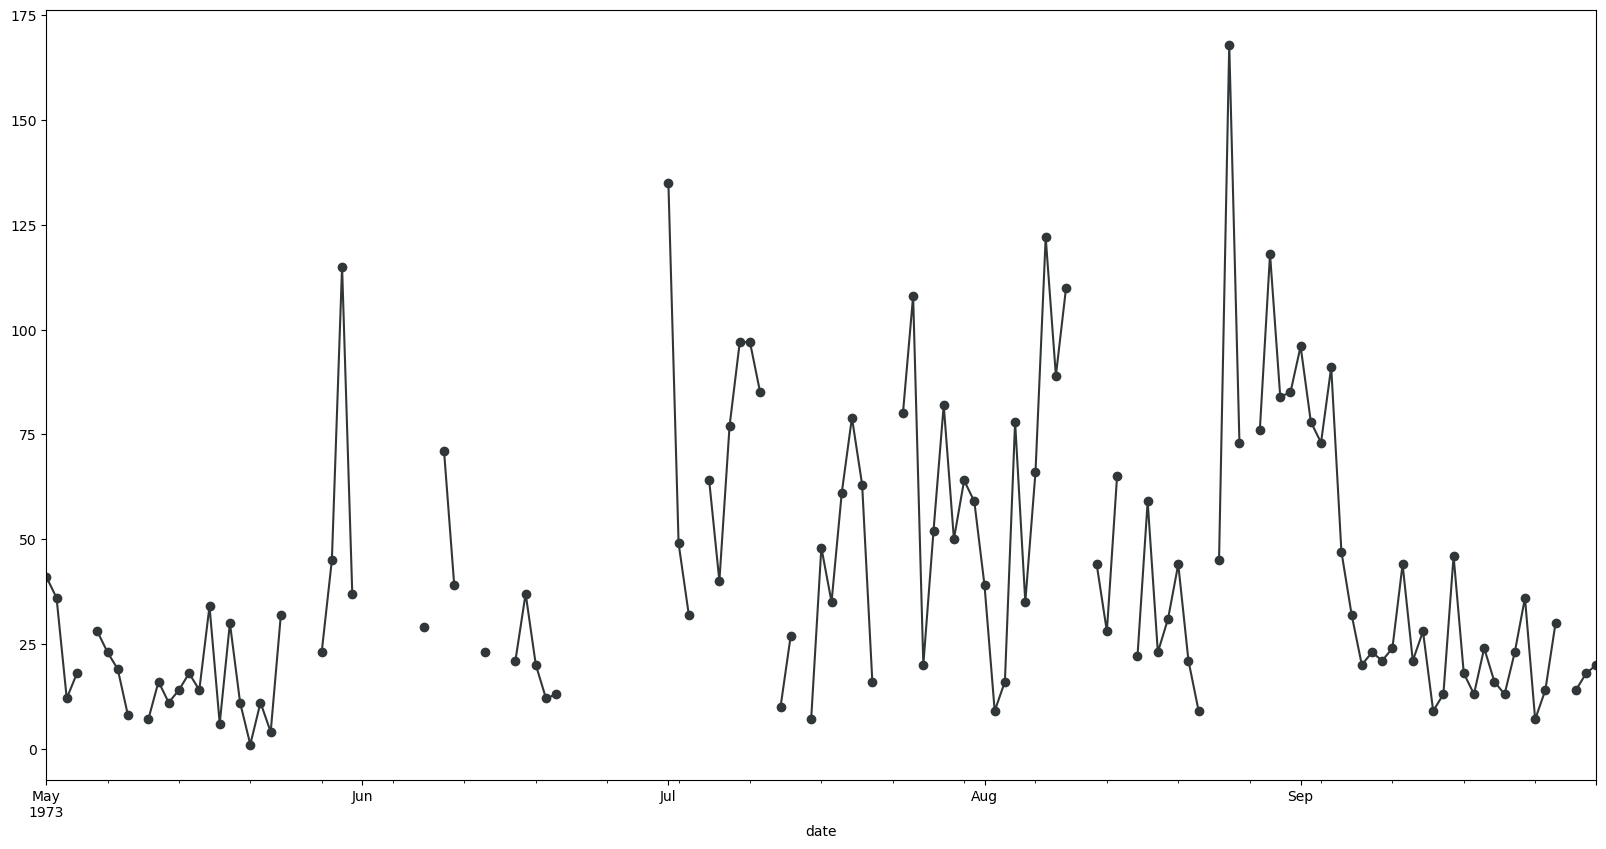

In [41]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

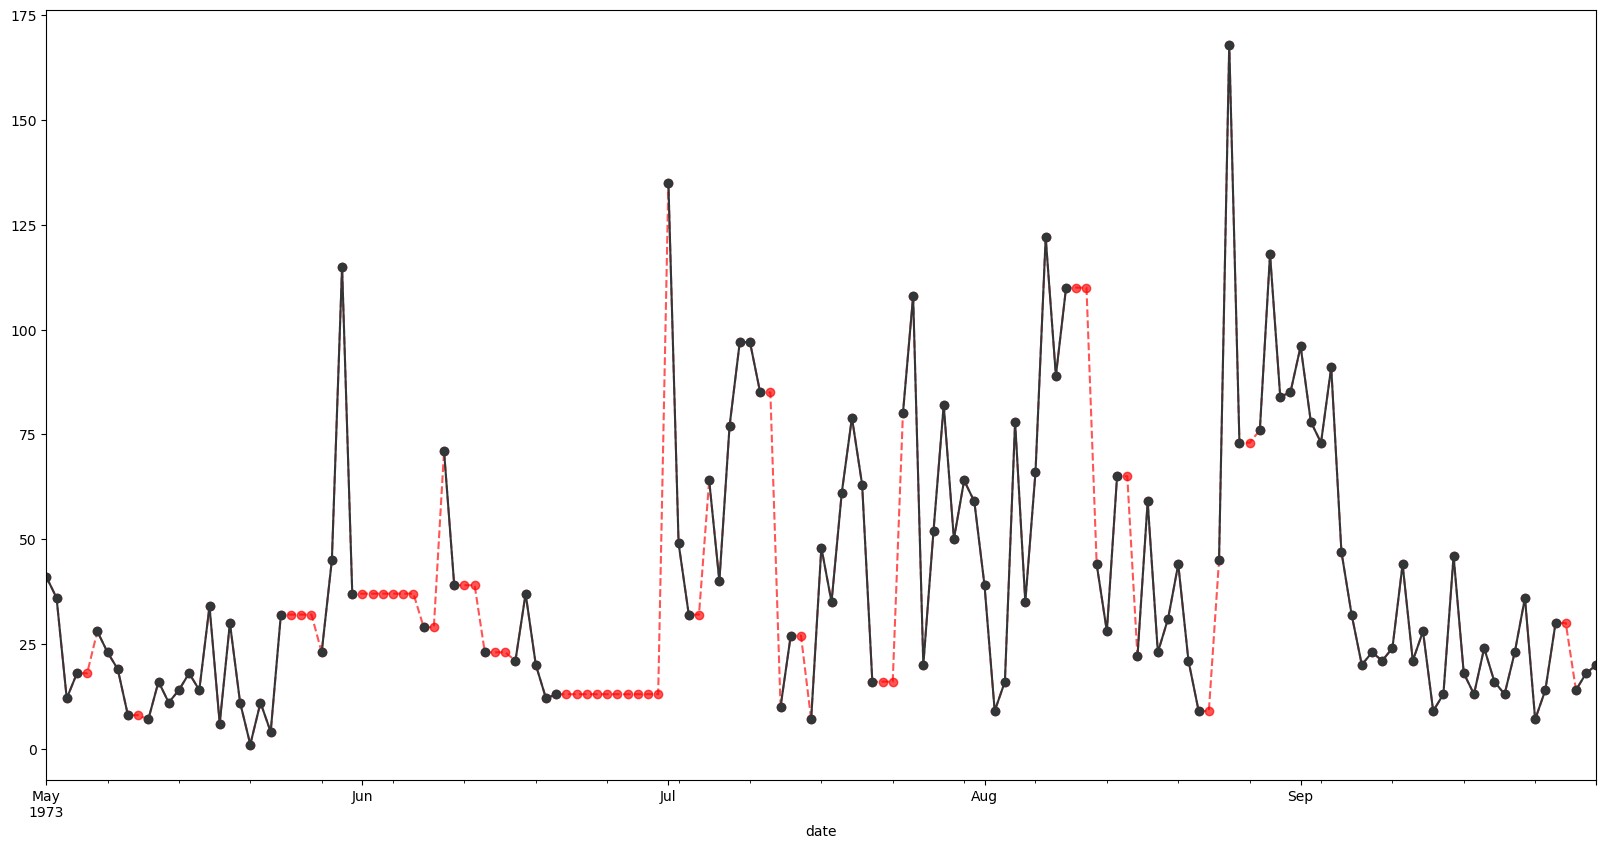

In [42]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

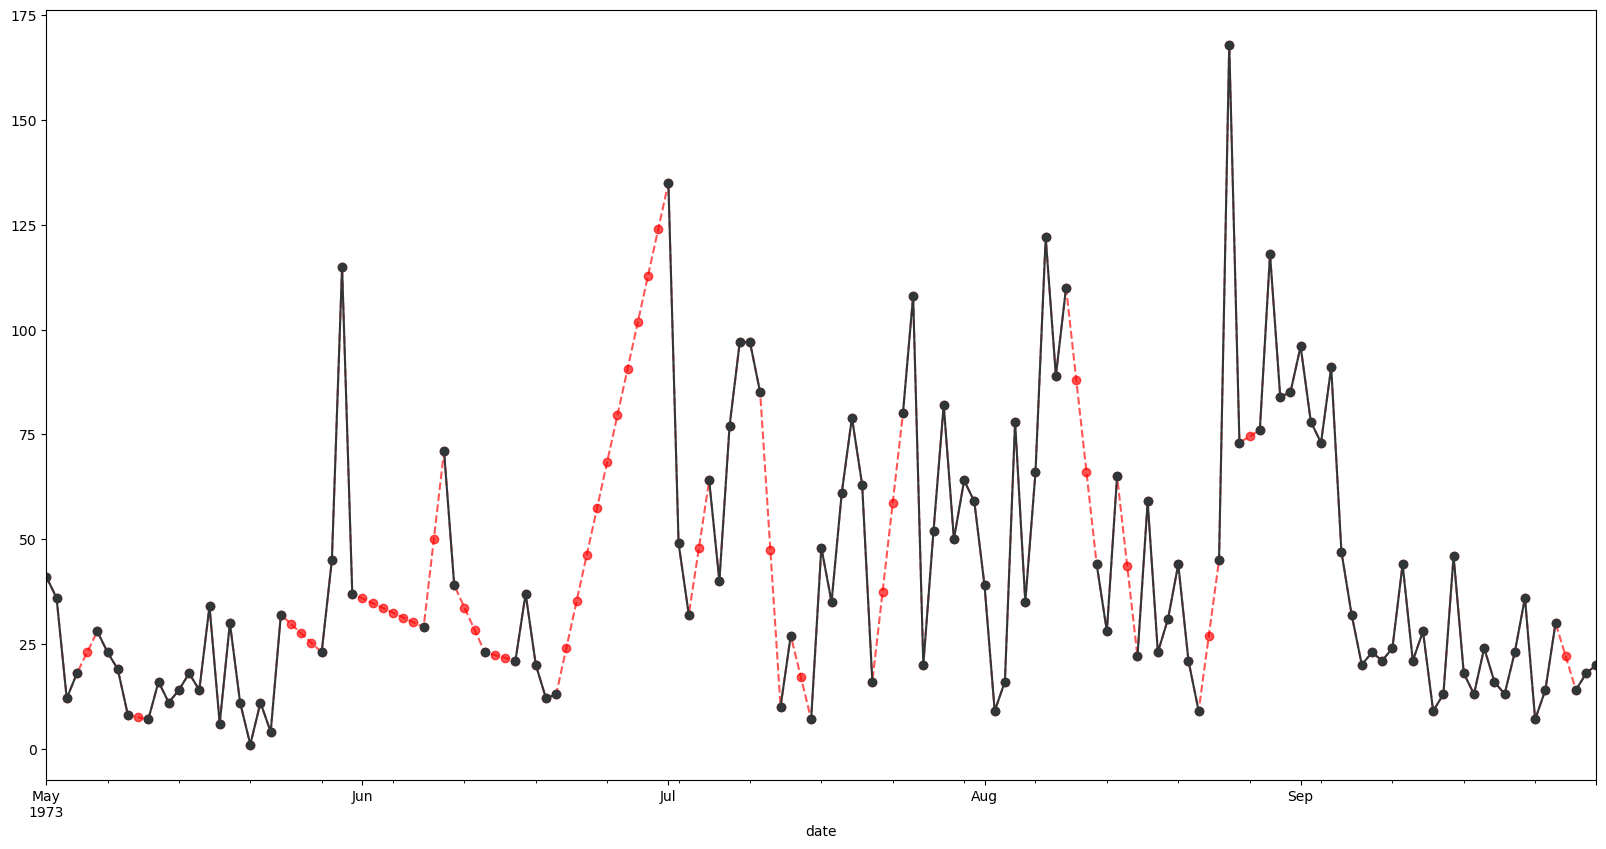

In [43]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

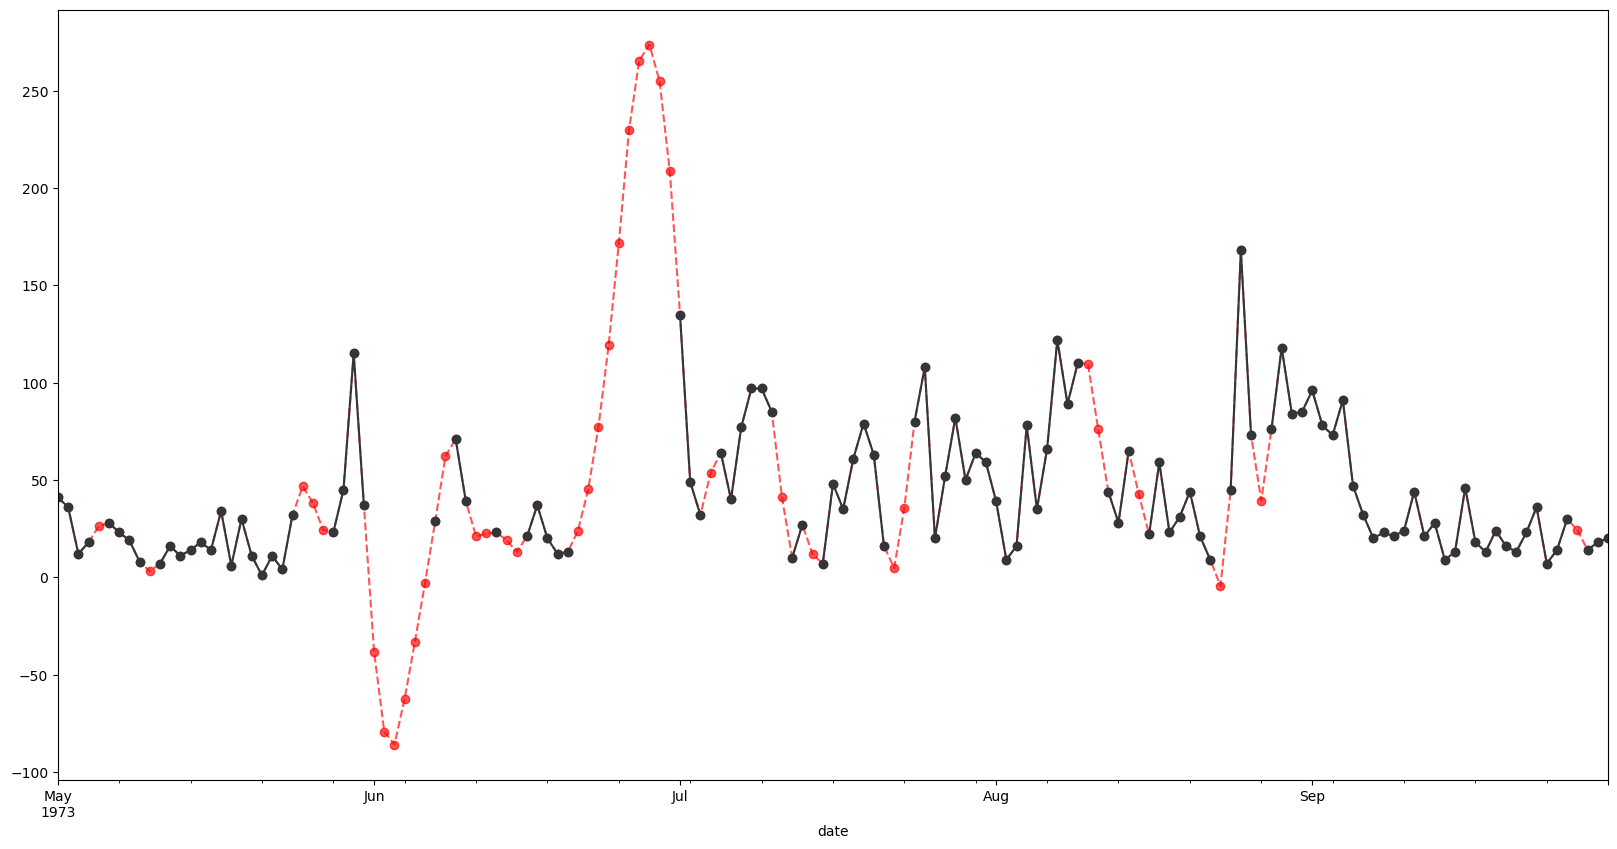

In [44]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "quadratic").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


(<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>)

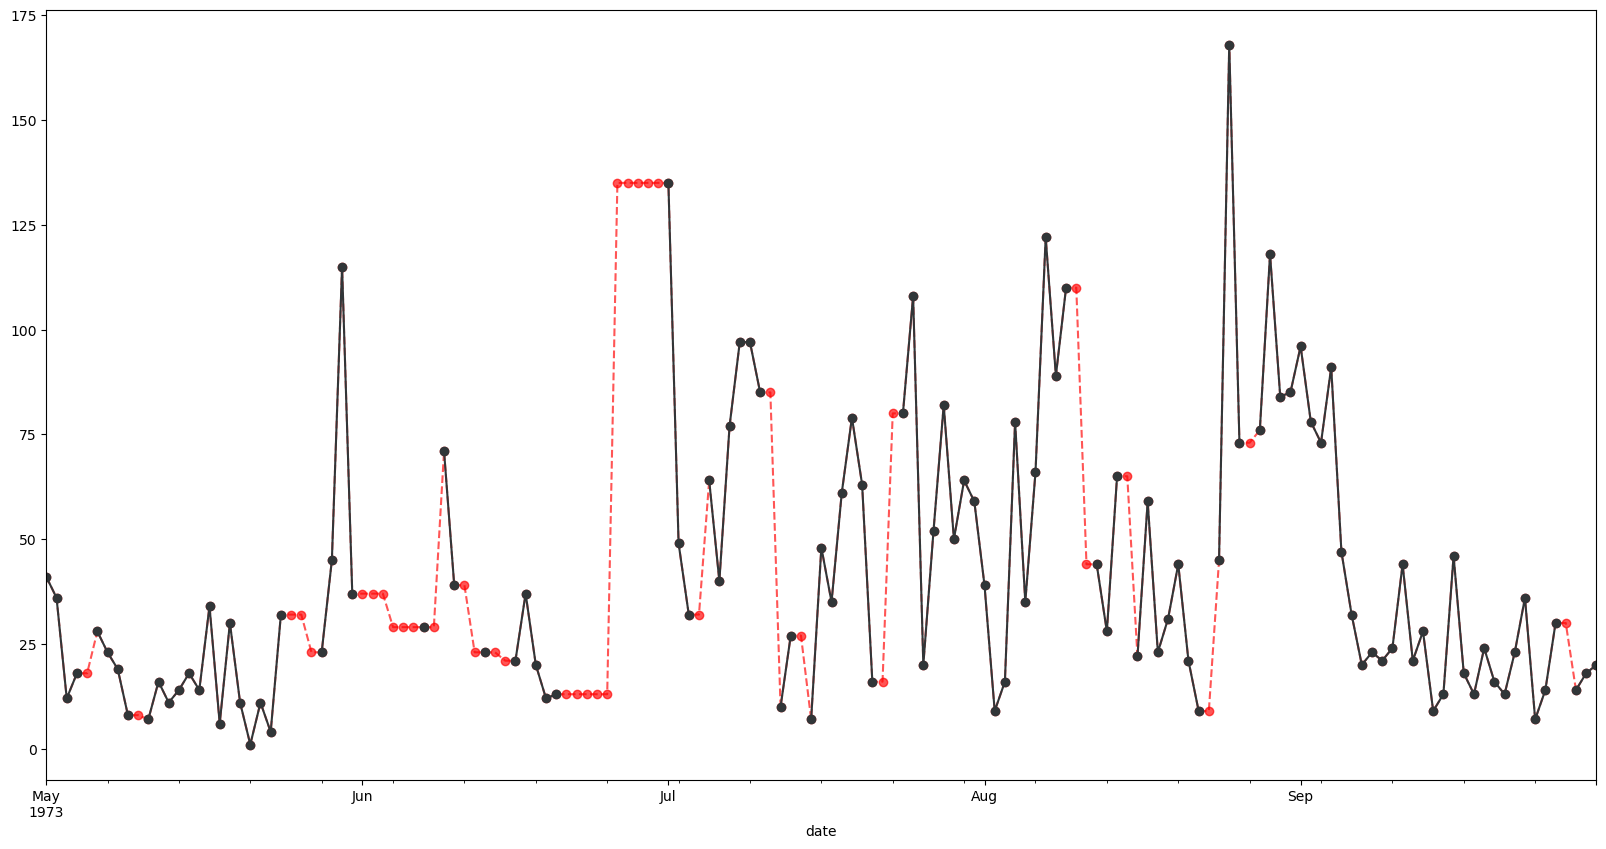

In [45]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "nearest").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

# K-Nearest Neighbors (KNN) Imputation

🔹 What does it consist of?
KNN imputation estimates missing values based on the proximity between data points. The algorithm calculates the similarity between the instance with missing values and the complete instances using metrics such as Euclidean distance. It then assigns the most common value or the average of the K nearest neighbors.

🔹 Advantages:

- Accuracy: Can provide precise imputations when data has a complex structure and nonlinear relationships.
- No explicit model required: Does not assume a specific data distribution, making it useful in situations where parametric assumptions are not feasible.

🔹 Disadvantages:

- Computationally expensive: Can be slow for large datasets, especially if K is high or if many features are used.
- Depends on data quality: If the data contains noise, imputations may not be accurate.
- Sensitive to the choice of K: The selection of the number of neighbors (K) is crucial. An incorrect K value can affect the accuracy of imputations.

🔹 When to use it?

- When data has complex relationships that do not fit well with simple methods like mean or median imputation.
- When dealing with numerical data, where instance similarity can be effectively determined using distance metrics.
- When there is a moderate amount of missing data, and computation time is not a major concern.

In [ ]:
# we cant work with categorical data, we need to encode it
categorical_columns = nhanes_df.select_dtypes(include=['object', 'category']).columns
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),  # Encoder, columns
    remainder="passthrough" # Keep the rest of the columns
)

In [48]:
nhanes_transformed_df = nhanes_df.copy(deep=True)
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),   # Fit and transform
        columns = categorical_transformer.get_feature_names_out(),  # Get the names of the columns
        index = nhanes_df.index     # Keep the index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [50]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round() # Use .round() cause the imputer returns float values that do not match the categorical values. Plus, all original values are integers
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<AxesSubplot:xlabel='height', ylabel='weight'>

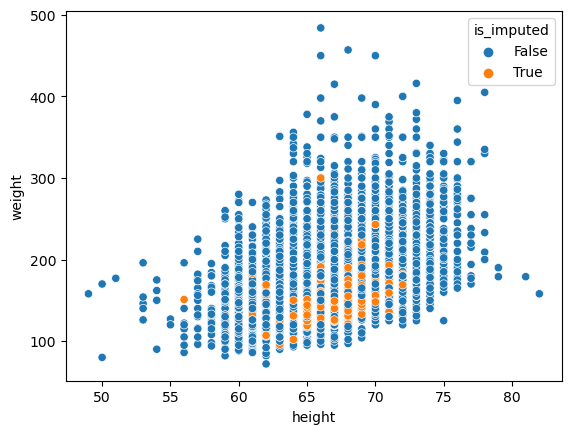

In [ ]:
# Plot the imputed values
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

It can be useful to sort by the number of missing variables, prioritizing the completion of rows with fewer missing values first. sklearn does this by default, so the result will be the same, but some libraries do not.

<AxesSubplot:xlabel='height', ylabel='weight'>

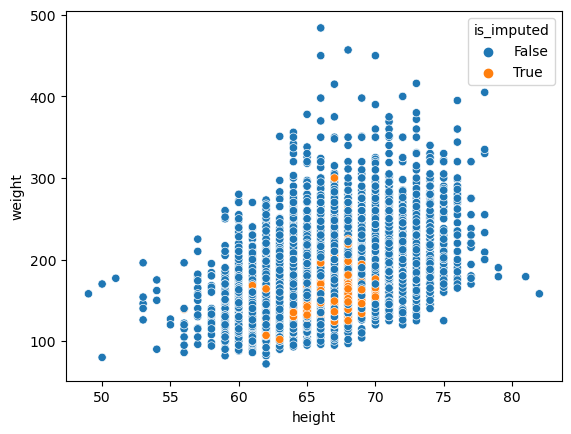

In [52]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors = 10)

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()

(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)